In [1]:

import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping    
from tensorflow.keras.callbacks import ReduceLROnPlateau 
import time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import kagglehub


# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Johnny\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


In [2]:


img_height = 224
img_width = 224
batch_size = 500

# Load the training data and split it into training and validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # 20% for validation
    subset="training",  # This will be the training set
)

# Load the validation data from the same directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    "train",  # Same directory as the training data
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # Same validation split
    subset="validation",  # This will be the validation set
)

# Load the test data from a separate test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    "test",  # This is assumed to be your separate test directory
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print class names for each dataset
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Validation Classes:")
class_names = val_ds.class_names
print(class_names)

print("Test Classes:")
class_names = test_ds.class_names
print(class_names)
num_classes = len(train_ds.class_names)  # Number of classes from your dataset
print(num_classes)


Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20001 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Validation Classes:
['FAKE', 'REAL']
Test Classes:
['FAKE', 'REAL']
2


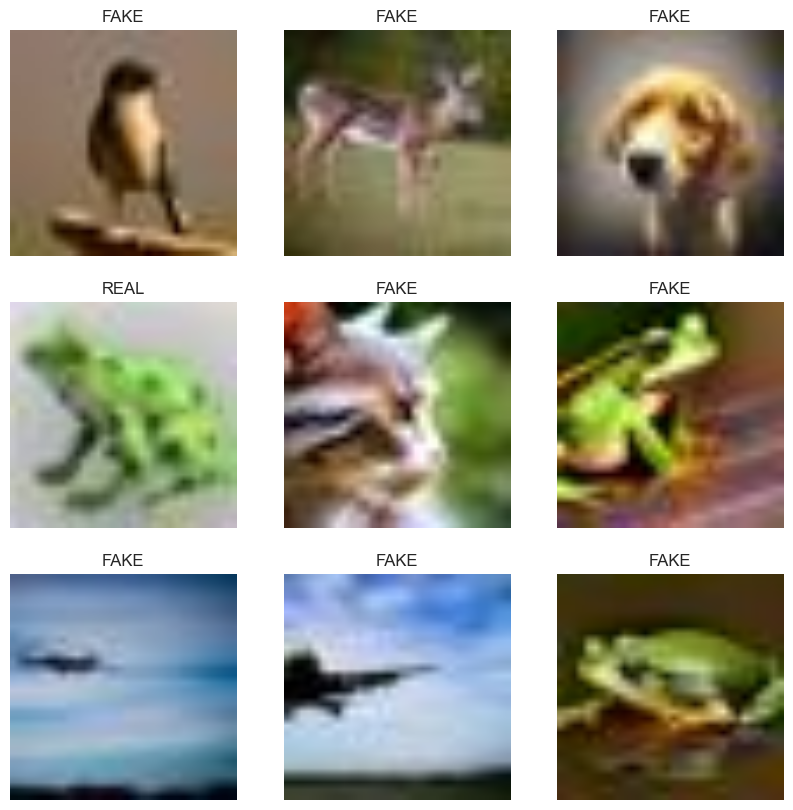

In [3]:
import matplotlib.pyplot as plt

# Retrieve class names from the original dataset before prefetching
class_names = train_ds.class_names  # Get class names from the training dataset

# Get a batch of images and labels from the training dataset
images, labels = next(iter(train_ds))  # Get the first batch from the training dataset

# Display the first 9 images in a 3x3 grid
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy array for display
    plt.title(class_names[labels[i].numpy()])  # Use class names for the title
    plt.axis('off')  # Hide axes for a cleaner display

plt.show()


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


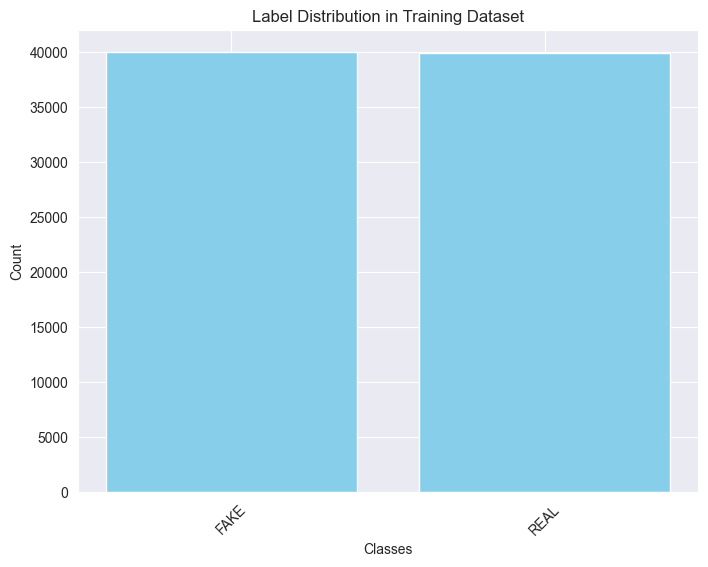

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store label counts
label_counts = [0] * len(class_names)

# Iterate over the entire dataset to count labels
for images, labels in train_ds:
    for label in labels.numpy():
        label_counts[label] += 1

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, label_counts, color='skyblue')
plt.title("Label Distribution in Training Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


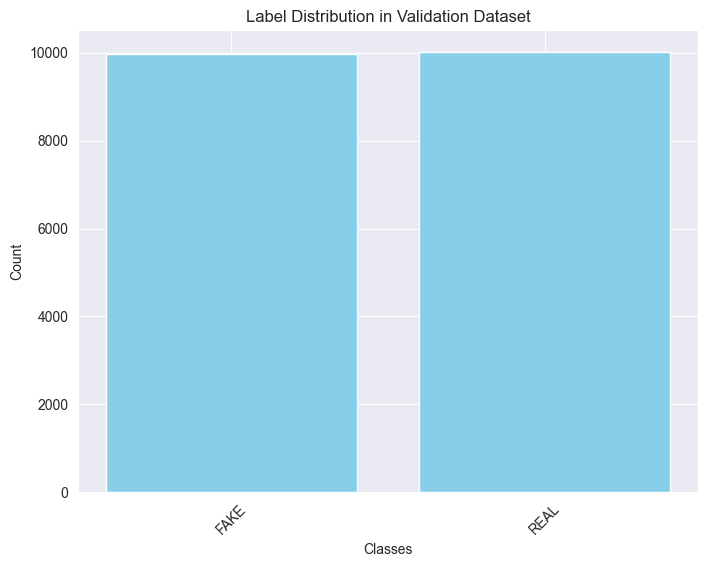

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store label counts
label_counts = [0] * len(class_names)

# Iterate over the entire dataset to count labels
for images, labels in val_ds:
    for label in labels.numpy():
        label_counts[label] += 1

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, label_counts, color='skyblue')
plt.title("Label Distribution in Validation Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


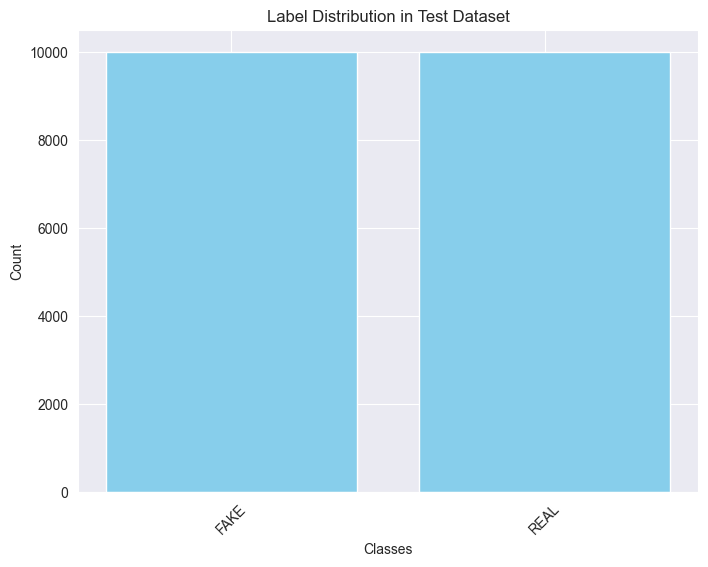

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store label counts
label_counts = [0] * len(class_names)

# Iterate over the entire dataset to count labels
for images, labels in test_ds:
    for label in labels.numpy():
        label_counts[label] += 1

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, label_counts, color='skyblue')
plt.title("Label Distribution in Test Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Define image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 500
# Define the ResNet50 model
def create_resnet_model():
    base_model = ResNet50(
        weights='imagenet',  # Use pre-trained weights on ImageNet
        input_shape=(img_height, img_width, 3),  # 3 channels for RGB images
        include_top=False  # Exclude the top (fully connected) layer
    )
    
    # Freeze the layers of the base model to retain pre-trained weights
    base_model.trainable = False

    # Create a custom head for the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions of the output
        layers.Dense(1024, activation='relu'),  # Fully connected layer
        layers.Dropout(0.5),  # Dropout layer for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
    ])
    
    return model

# Create the model
model = create_resnet_model()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # Since labels are integers
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
callbacks = [
    # Save the model after every epoch, only if the validation accuracy improves
    ModelCheckpoint('nn.keras', 
                    monitor='val_accuracy', 
                    save_best_only=True, 
                    mode='max', 
                    verbose=1),

    # Stop training early if no improvement in validation accuracy after 5 epochs
    EarlyStopping(monitor='val_accuracy', 
                  patience=5, 
                  mode='max', 
                  verbose=1),

    # Reduce learning rate by a factor of 0.1 if validation accuracy stops improving
    ReduceLROnPlateau(monitor='val_accuracy', 
                      factor=0.1, 
                      patience=3, 
                      mode='max', 
                      verbose=1),

    # Use TensorBoard for logging training metrics
    TensorBoard(log_dir='./logs')
]

In [ ]:
# Finally, train the model

print("Starting training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  verbose=1,
  callbacks=callbacks
)
print("Training finished.")

Starting training...
Epoch 1/100
 11/160 ━━━━━━━━━━━━━━━━━━━━ 57:10 23s/step - accuracy: 0.5144 - loss: 4.2967

In [ ]:
model.save("nn.h5")


In [ ]:
new = keras.models.load_model("nn.h5")
new.evaluate(test_ds, verbose = 2)

41/41 - 6s - 150ms/step - accuracy: 0.9338 - loss: 0.1685 - precision: 0.9318 - recall: 0.9361


[0.16852888464927673,
 0.9338033199310303,
 0.931813657283783,
 0.9361000061035156]

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step


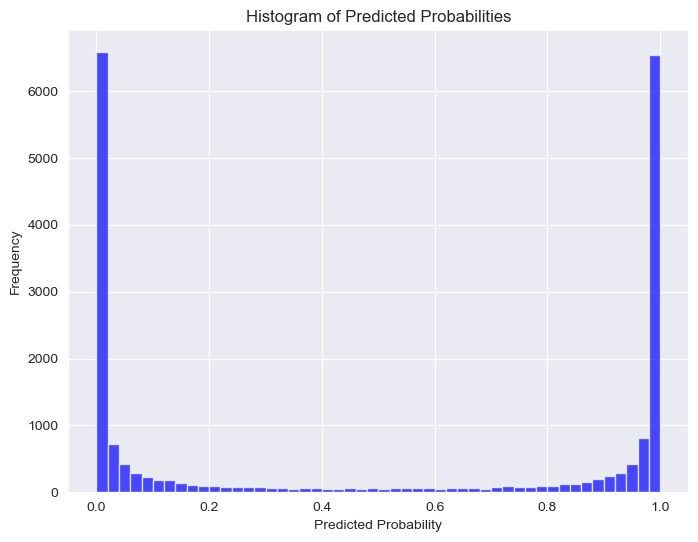

In [ ]:
# Prediction analysis
y_pred = new.predict(test_ds)

# Convert to binary so we can use in confusion_matrix
y_pred_binary = (y_pred > 0.5).astype(int)

plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize empty lists to hold true labels and predictions
y_true = []
y_pred = []

# Iterate over the test dataset and collect the true labels and predictions
for images, labels in test_ds:
    # Append the true labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array
    
    # Make predictions (assuming the model has been defined and compiled)
    predictions = model.predict(images)
    
    # Convert predictions to binary labels (0 or 1 for binary classification)
    # If you're using a sigmoid activation for binary classification, use np.round to get 0 or 1
    y_pred.extend(np.round(predictions))  # For binary classification

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/

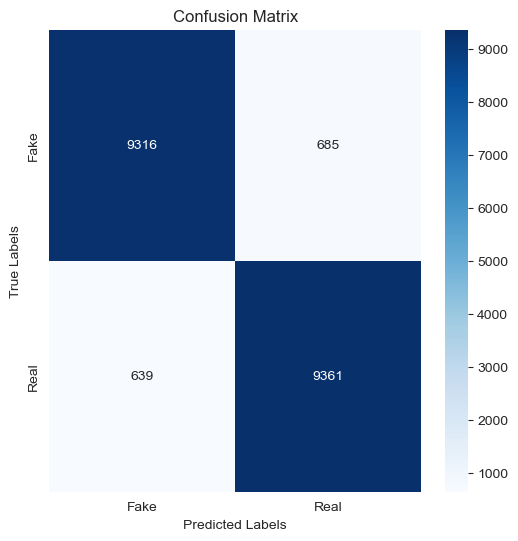

In [ ]:
# Confusion Matrix

model_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(model_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()